C:\Users\Lavanya R\AppData\Local\Temp\ipykernel_17804\840460507.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['bhk']=df2['size'].apply(lambda x: int(x.split(' ')[0]))
C:\Users\Lavanya R\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Lavanya R\anaconda3\Lib\site-packages

189.1234907406234

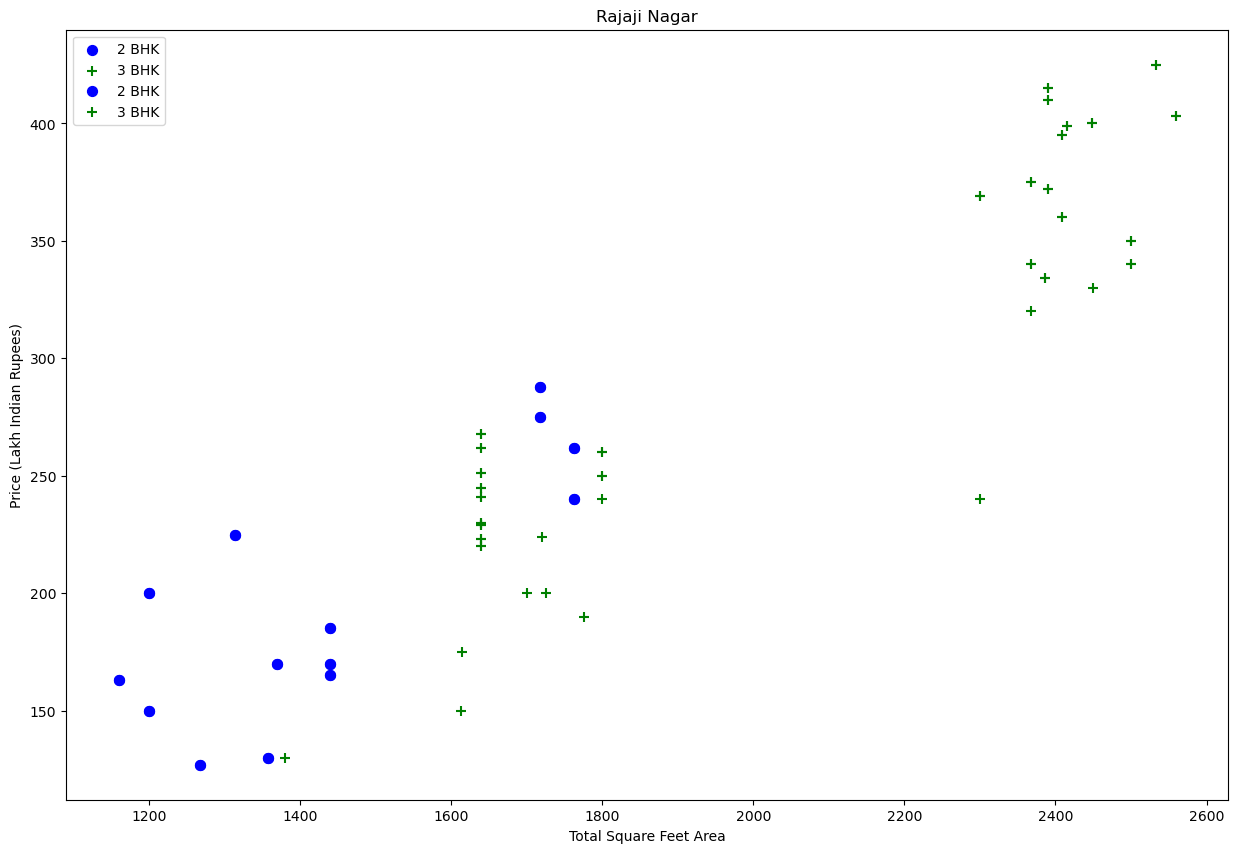

In [2]:
import pandas as pd

df=pd.read_csv(r"C:\Users\Lavanya R\Downloads\Bengaluru_House_Data.csv")

df.head()

df1=df.drop(['area_type','availability','society','balcony'],axis='columns')
df1.head()

df1.isna().sum()

df2=df1.dropna()
df2.isna().sum()
df2.shape

df2['bhk']=df2['size'].apply(lambda x: int(x.split(' ')[0]))
df2

df2.head()

def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

df2[~df2['total_sqft'].apply(is_float)].head(10)

def convert_sqft_to_num(x):
    token=x.split("-")
    if len(token)==2:
        return(float(token[0])+float(token[1]))/2
    try:
        return float(x)
    except:
        return None


df3=df2.copy()
df3.total_sqft=df3.total_sqft.apply(convert_sqft_to_num)
df3= df3[df3.total_sqft.notnull()]
df3.head()

df3.loc[30]

df5 = df3.copy()
df5['price_per_sqft'] = df5['price']*100000/df5['total_sqft']
df5.head()


df5_stats = df5['price_per_sqft'].describe()
df5_stats

df5.to_csv("bhp.csv",index=False)


loction_stats=df5['location'].value_counts(ascending=False)

loction_stats

loction_stats.sum()
len(loction_stats[loction_stats>10])

len(loction_stats)

len(loction_stats[loction_stats<=10])

location_stats_less_than_10=loction_stats[loction_stats<=10]
location_stats_less_than_10

df5['location']=df5['location'].apply(lambda x: 'other' if x in location_stats_less_than_10 else x)

len(df5.location.unique())

df5[df5.total_sqft/df5.bhk<300].head()

df5.shape

df6=df5[~(df5.total_sqft/df5.bhk<300)]

df6.shape

import numpy as np
def remove_outliers(df):
    df_out=pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m=np.mean(subdf.price_per_sqft)
        st=np.std(subdf.price_per_sqft)
        reduced_df=subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out=pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
            
                         
df7=remove_outliers(df6)                         

      

df7.shape

from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib 
matplotlib.rcParams["figure.figsize"] = (20,10)



def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(df7,"Rajaji Nagar")

def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df8 = remove_bhk_outliers(df7)
# df8 = df7.copy()
df8.shape

plot_scatter_chart(df8,"Rajaji Nagar")

df9=df8[df8.bath<df8.bhk+2]

df9.shape

df10 = df9.drop(['size','price_per_sqft'],axis='columns')
df10.head(3)

dumies=pd.get_dummies(df10.location)

df11=pd.concat([df10,dumies],axis="columns")

df11=df11.drop(['location'],axis="columns")

dumies

y=df11['price']

df12=df11.drop(['price','other'],axis="columns")

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(df12,y,test_size=0.3,random_state=10)

from sklearn.linear_model import LinearRegression

l=LinearRegression()
l.fit(x_train,y_train)


l.score(x_test,y_test)

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv=ShuffleSplit(n_splits=5,test_size=0.2,random_state=0)
cross_val_score(LinearRegression(),df11,y,cv=cv)

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(df12,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'copy_X': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(df11,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])
find_best_model_using_gridsearchcv(df12,y)


import numpy as np

def predict_price(location,sqft,bath,bhk):    
    loc_index = np.where(df12.columns==location)[0][0]

    x = np.zeros(len(df12.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1

    return l.predict([x])[0]

predict_price('1st Phase JP Nagar',1000, 2, 2)

predict_price('1st Phase JP Nagar',1000, 3, 3)

predict_price('Indira Nagar',1000, 2, 2)

predict_price('Indira Nagar',1000, 3, 3)

